In [26]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from numpy import random
from numpy.random import randn
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import kf_book.book_plots as bp
from scipy.linalg import block_diag
# read from csv and save corresponding column data to variables
df = pd.read_csv('point1.csv')
# transfer unit to meter
y = df.y.div(1000)
x = df.x.div(1000)
# l = len(y)
x_mean = np.mean(x)
y_mean = np.mean(y)
process_std = 0.028
process_var = 0.028 ** 2
process_var_lateral = 0.019 **2
sensor_std = 0.077
sensor_var = 0.077 ** 2
sensor_var_lateral = 0.125 ** 2

In [3]:
x_mean

5.799013605442178

In [4]:
y_mean

4.865020408163268

In [8]:
N = 8
points = []
xs = []
ys = []
for i in range(1, N + 1):
    df = pd.read_csv(f'point{i}.csv')
    # transfer unit to meter
    y = df.y.div(1000)
    x = df.x.div(1000)
    # l = len(y)
    x_mean = np.mean(x)
    xs.append(x_mean)
    y_mean = np.mean(y)
    ys.append(y_mean)
    points.append([x_mean, y_mean])

print(f"xs: {xs}\tys: {ys}")

xs: [5.799013605442178, 5.677136752136748, 5.70306106870229, 5.09885606060606, 5.120082644628101, 4.572519379844961, 4.478495575221241, 2.03554054054054]	ys: [4.865020408163268, 4.234247863247866, 3.7864122137404563, 3.554515151515152, 3.1047024793388442, 2.931767441860464, 2.4959646017699106, 2.353558558558559]


In [10]:
xs = [5.799013605442178, 5.677136752136748, 5.70306106870229, 5.09885606060606, 5.120082644628101, 4.572519379844961, 4.478495575221241, 2.03554054054054]
ys = [4.865020408163268, 4.234247863247866, 3.7864122137404563, 3.554515151515152, 3.1047024793388442, 2.931767441860464, 2.4959646017699106, 2.353558558558559]

In [61]:
def generate(i):
    df1 = pd.read_csv(f'exp{i}_2506.csv')
    uwb_x1 = df1.uwb_x
    uwb_y1 = df1.uwb_y
    vel_linear_x1 = df1['vel_linear_x'].fillna(0.0)
    # first nonzero value for uwb_x
    ini_index1 = uwb_x1.ne(0).idxmax()
    def track():
        tracker = KalmanFilter(dim_x=4, dim_z=2)
        dt = 0.01
        tracker.F = np.array([[1, dt, 0,  0],
                              [0,  1, 0,  0],
                              [0,  0, 1, dt],
                              [0,  0, 0,  1]])
        tracker.u = 0.
        tracker.H = np.array([[1., 0., 0., 0], [0., 0., 1., 0.]])

        tracker.R = np.array([[sensor_var, 0], [0, sensor_var_lateral]])
        q_forward = Q_discrete_white_noise(dim=2, dt=dt, var=process_var)
        q_lateral = Q_discrete_white_noise(dim=2, dt=dt, var=process_var_lateral)
        tracker.Q = block_diag(q_forward, q_lateral)
    #     print(f"Q = {tracker.Q}")
        tracker.x = np.array([[uwb_x1[ini_index1], vel_linear_x1[0], uwb_y1[ini_index1], 0]]).T
        tracker.P = np.eye(4) * 0.5
        return tracker
    # robot circle movement
    N = len(uwb_x1[ini_index1:])
    zs1 = np.array([[uwb_x1[i], uwb_y1[i]] for i in range(ini_index1, N)])

    # run filter
    robot_tracker = track()
    # batch_filter is quite slow
    mu, cov, _, _ = robot_tracker.batch_filter(zs1[ini_index1:])

    # plot result
    plt.figure(figsize=(16, 12), dpi=80)
    plt.rcParams.update({'font.size': 24})
    # c for color in plot_filter
    bp.plot_filter(mu[:, 0], mu[:, 2], c='k')
    bp.plot_measurements(zs1[ini_index1:, 0], zs1[ini_index1:, 1], color='c')
#     plt.title('Kalman Filter position for robot movement under remote control')
    plt.xlabel("X-coordinate (m)")
    plt.ylabel("Y-coordinate (m)")
    # plt.annotate("Start", xy=(zs1[ini_index1][0], zs1[ini_index1][1]), xytext=(zs1[ini_index1][0] + 100, zs1[ini_index1][1] - 10), textcoords='offset points', ha='center', va='bottom',color='blue',
    #          bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
    #          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.05', 
    #                             color='green'))
    # plt.annotate("End", xy=(zs1[-1][0], zs1[-1][1]), xytext=(zs1[-1][0] - 100, zs1[-1][1]), textcoords='offset points', ha='center', va='bottom',
    #          bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
    #          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
    #                             color='red'))
    plt.plot(xs, ys, '-o', color='m', label='Track')
    plt.annotate("Start", xy=(mu[0][0], mu[0][2]), xytext=(mu[0][0] - 100, mu[0][2] - 10), textcoords='offset points', ha='center', va='bottom',color='blue',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                                color='green'))
    plt.annotate("End", xy=(mu[-1][0], mu[-1][2]), xytext=(mu[-1][0], mu[-1][2] + 50), textcoords='offset points', ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
                                color='red'))
    plt.legend(loc='best')
    plt.savefig(f"exp{i}.pdf", dpi=300)

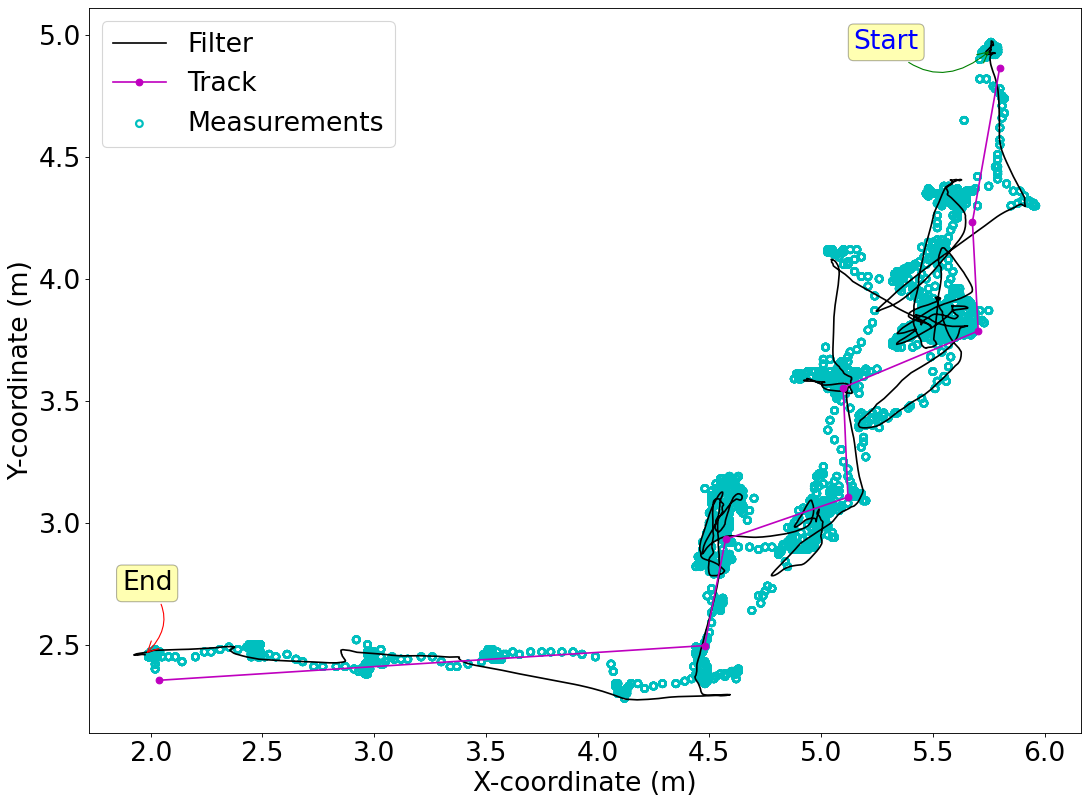

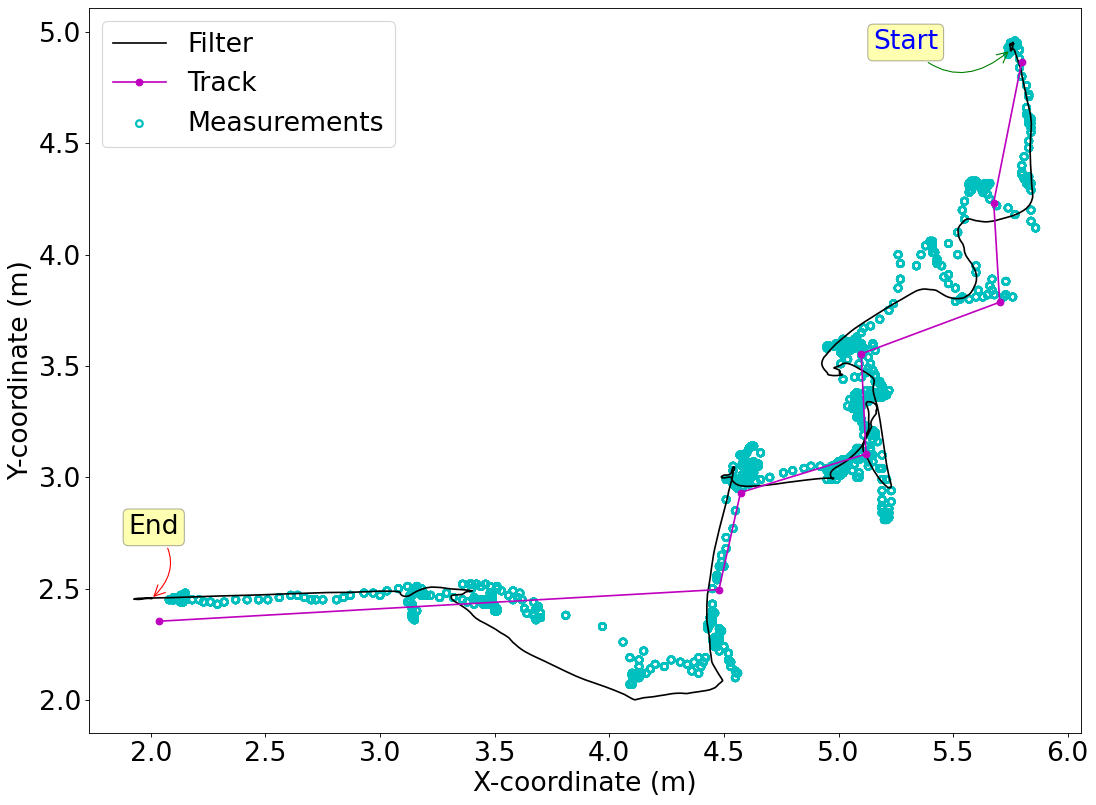

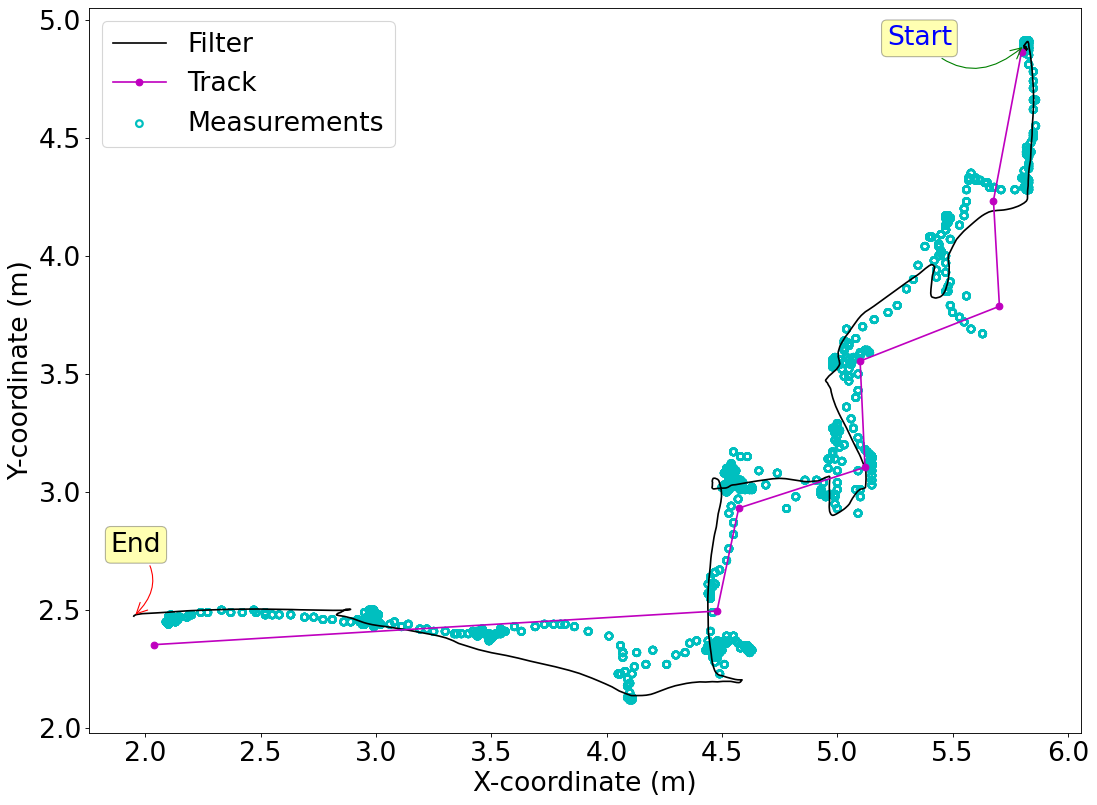

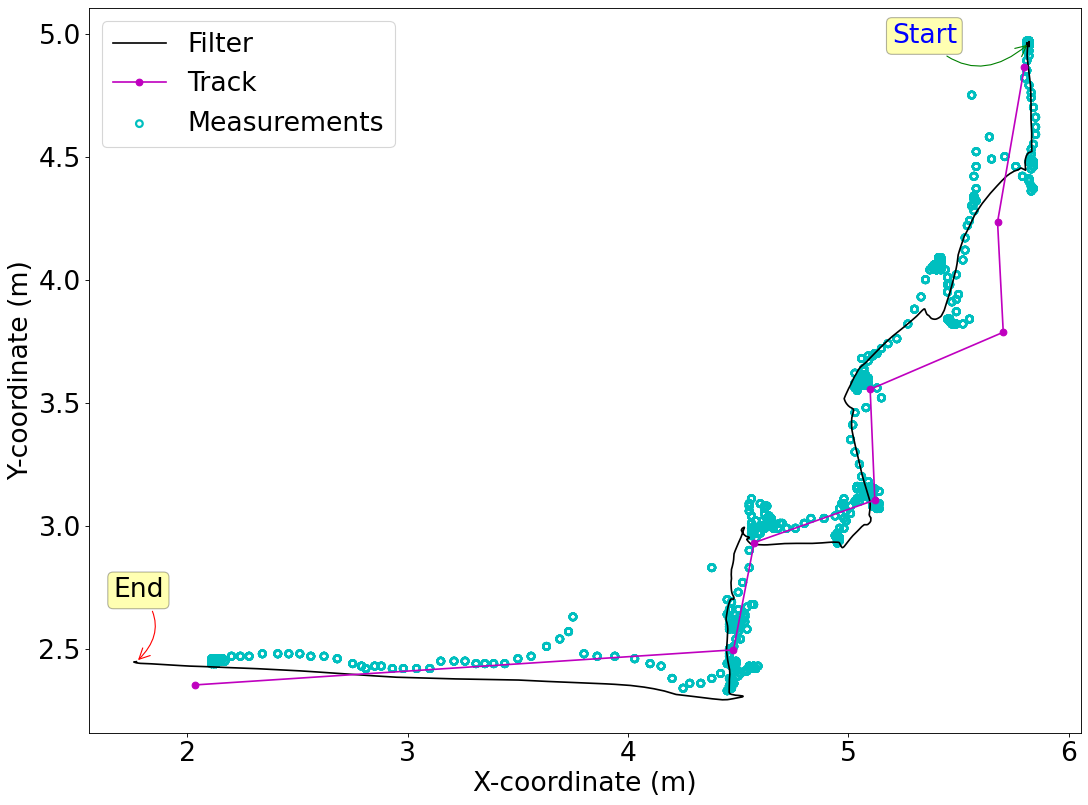

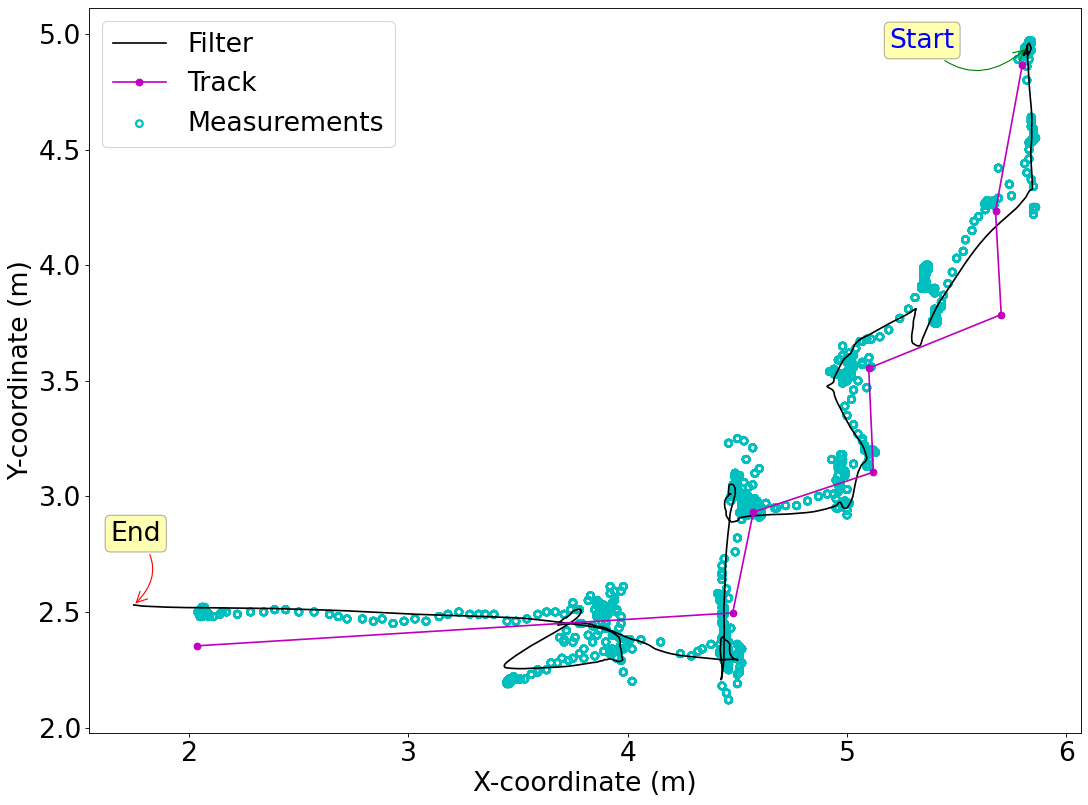

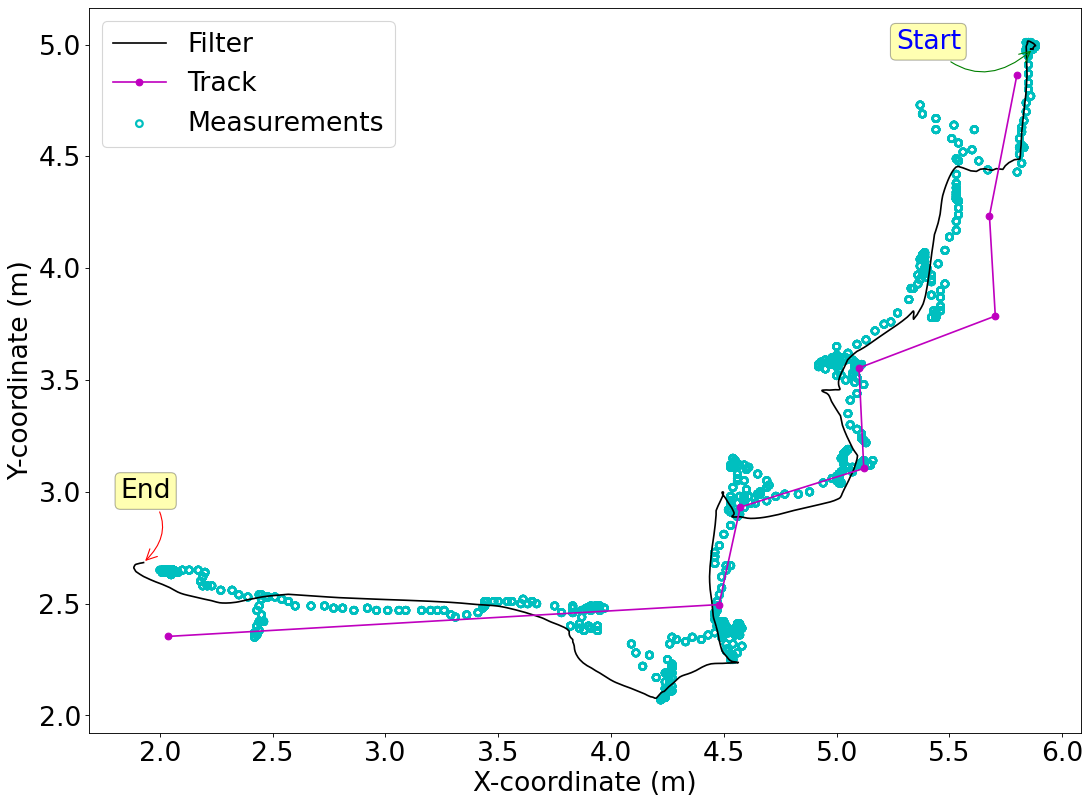

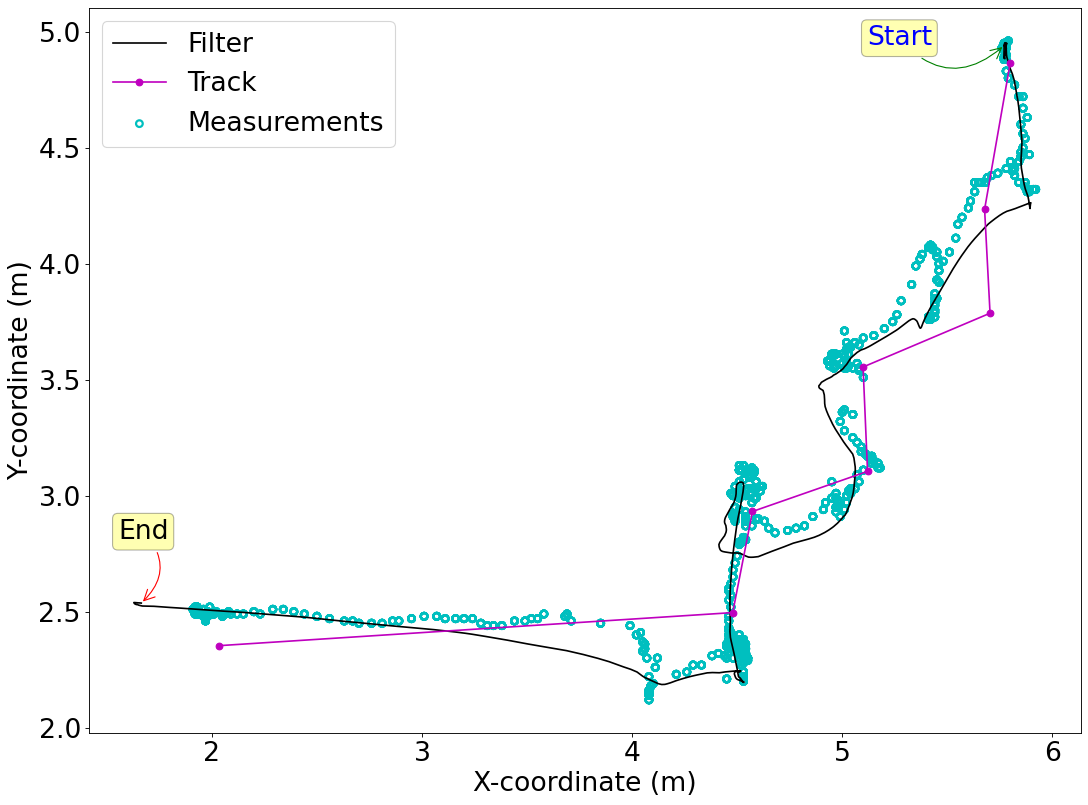

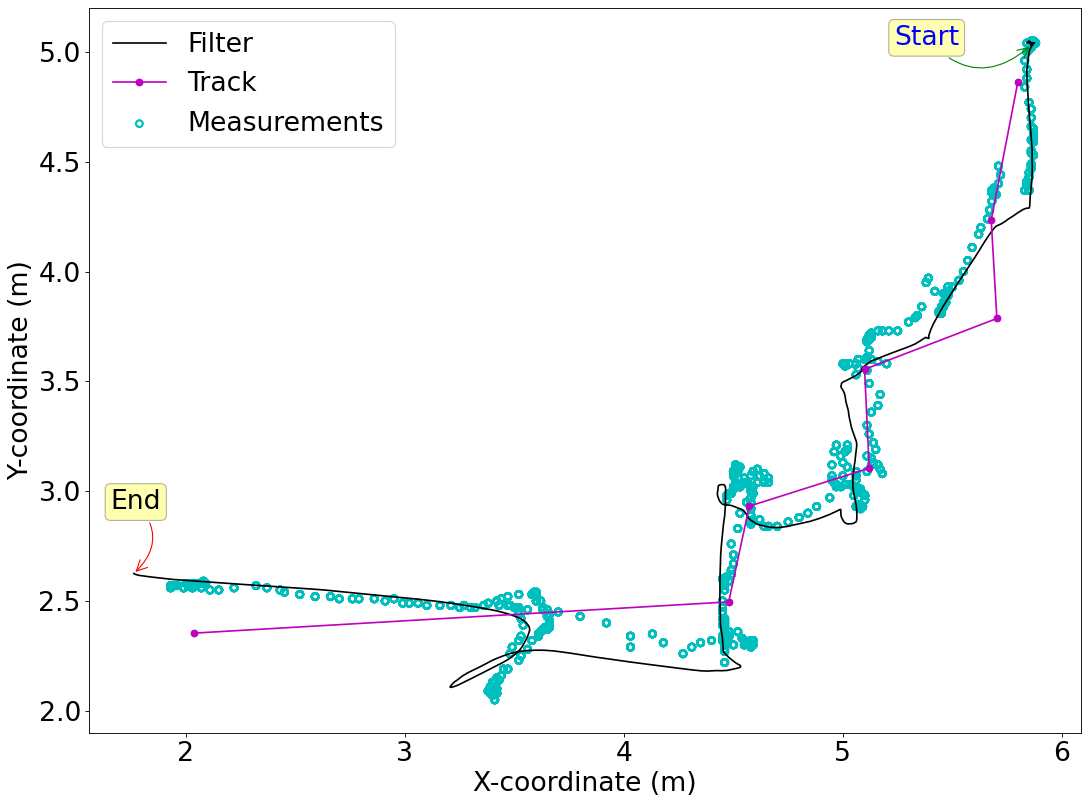

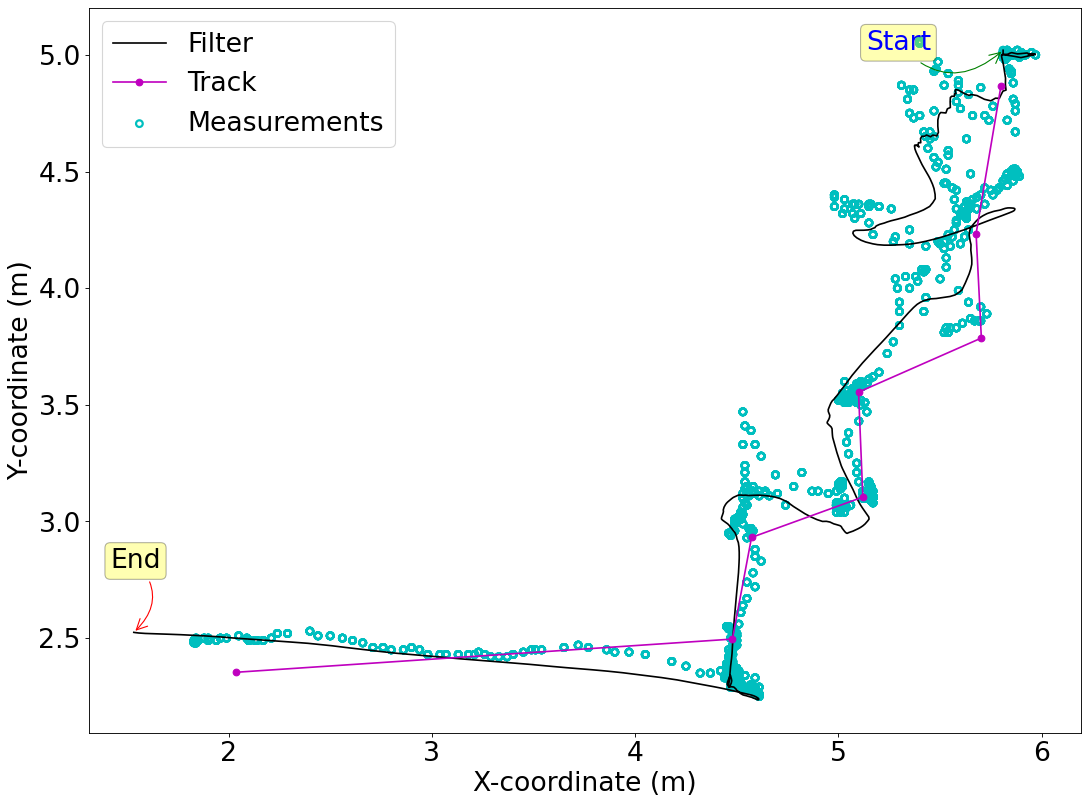

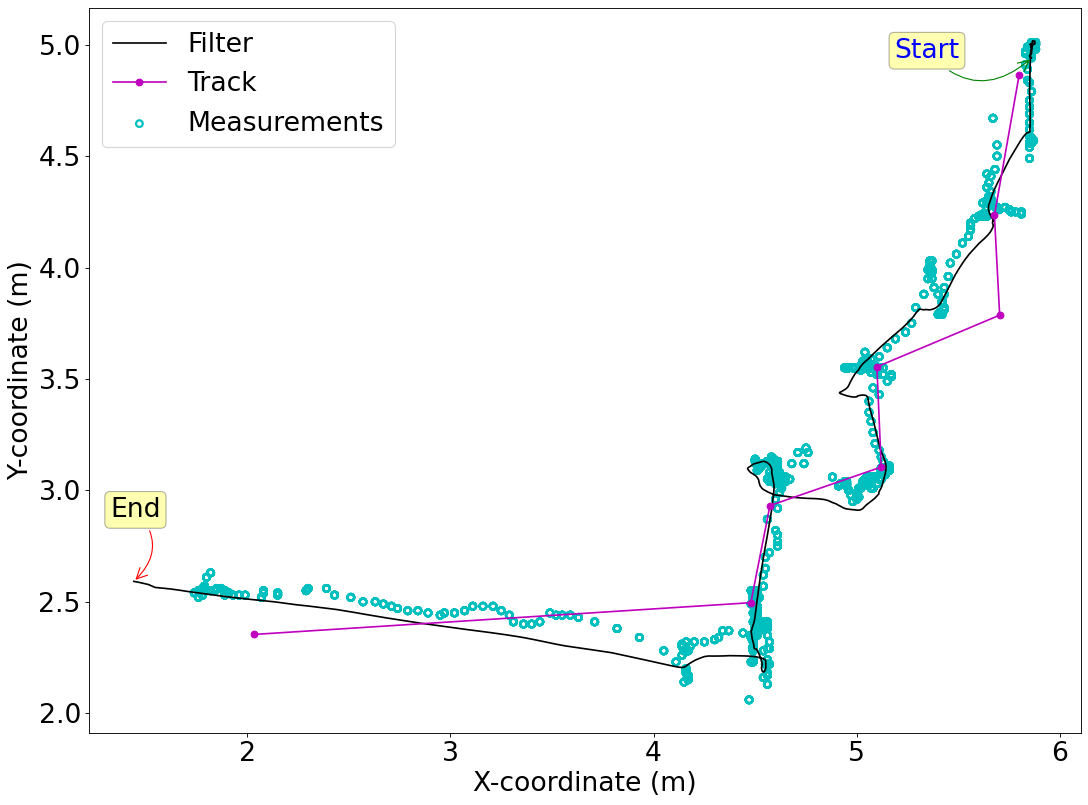

In [62]:
# generate plot for all experiments
for i in range(1, 11):
    generate(i)